In [1]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, f1_score
import matplotlib.pyplot as plt

In [2]:
# Data Preprocessing
class DataProcessor:
    def __init__(self, train_path, test_path, max_features=5000):
        self.train_path = train_path
        self.test_path = test_path
        self.max_features = max_features
        self.vocab = {}

    def load_data(self, path):
        df = pd.read_csv(path)
        df.dropna(inplace=True)
        df['category'] = df['category'].apply(lambda x: x.split(','))
        return df

    def tokenize(self, text):
        text = re.sub(r'[^a-zA-Z0-9 ]', '', text.lower())
        return text.split()

    def build_vocab(self, texts):
        counter = Counter()
        for text in texts:
            counter.update(self.tokenize(text))
        self.vocab = {word: i for i, (word, _) in enumerate(counter.most_common(self.max_features))}

    def compute_tfidf(self, texts):
        tfidf_matrix = np.zeros((len(texts), self.max_features))
        for i, text in enumerate(texts):
            words = self.tokenize(text)
            word_counts = Counter(words)
            for word, count in word_counts.items():
                if word in self.vocab:
                    tfidf_matrix[i, self.vocab[word]] = count
        return tfidf_matrix

    def process_data(self):
        train_df = self.load_data(self.train_path)
        test_df = self.load_data(self.test_path)
        
        self.build_vocab(train_df['document'])
        X_train = self.compute_tfidf(train_df['document'])
        X_test = self.compute_tfidf(test_df['document'])
        
        mlb = MultiLabelBinarizer()
        Y_train = mlb.fit_transform(train_df['category'])
        Y_test = mlb.transform(test_df['category'])
        
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
        
        return X_train, X_val, X_test, Y_train, Y_val, Y_test, mlb.classes_

In [3]:
# MLP Model
class MLP:
    def __init__(self, input_size, hidden_layers, output_size, activation='relu', learning_rate=0.01):
        self.learning_rate = learning_rate
        self.activation = activation
        
        # Initialize layers
        layer_sizes = [input_size] + hidden_layers + [output_size]
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01 for i in range(len(layer_sizes) - 1)]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]
    
    def activate(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        return x
    
    def activate_derivative(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            sig = self.activate(x)
            return sig * (1 - sig)
        elif self.activation == 'tanh':
            return 1 - np.tanh(x)**2
        return np.ones_like(x)
    
    def forward(self, X):
        activations = [X]
        zs = []
        for W, b in zip(self.weights, self.biases):
            z = activations[-1] @ W + b
            zs.append(z)
            activations.append(self.activate(z))
        return activations, zs
    
    def backward(self, X, Y, activations, zs):
        gradients_w = [np.zeros_like(W) for W in self.weights]
        gradients_b = [np.zeros_like(b) for b in self.biases]
        
        # Compute loss gradient
        delta = activations[-1] - Y
        
        # Backpropagate
        for i in reversed(range(len(self.weights))):
            gradients_w[i] = activations[i].T @ delta
            gradients_b[i] = np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                delta = (delta @ self.weights[i].T) * self.activate_derivative(zs[i-1])
        
        return gradients_w, gradients_b
    
    def update_weights(self, gradients_w, gradients_b, batch_size):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * (gradients_w[i] / batch_size)
            self.biases[i] -= self.learning_rate * (gradients_b[i] / batch_size)
    
    def train(self, X_train, Y_train, epochs=10, batch_size=32):
        losses = []
        for epoch in range(epochs):
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                Y_batch = Y_train[i:i+batch_size]
                activations, zs = self.forward(X_batch)
                gradients_w, gradients_b = self.backward(X_batch, Y_batch, activations, zs)
                self.update_weights(gradients_w, gradients_b, batch_size)
            loss = np.mean((self.forward(X_train)[0][-1] - Y_train) ** 2)
            losses.append(loss)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
        
        # Plot the loss
        plt.plot(range(epochs), losses, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.show()
    
    def predict(self, X):
        return self.forward(X)[0][-1] > 0.5

In [4]:
# Initialize Data Processing
processor = DataProcessor('./train.csv', './test.csv')
X_train, X_val, X_test, Y_train, Y_val, Y_test, classes = processor.process_data()


Epoch 1/10, Loss: 0.0115
Epoch 2/10, Loss: 0.0114
Epoch 3/10, Loss: 0.0113
Epoch 4/10, Loss: 0.0111
Epoch 5/10, Loss: 0.0109
Epoch 6/10, Loss: 0.0106
Epoch 7/10, Loss: 0.0101
Epoch 8/10, Loss: 0.0097
Epoch 9/10, Loss: 0.0094
Epoch 10/10, Loss: 0.0091


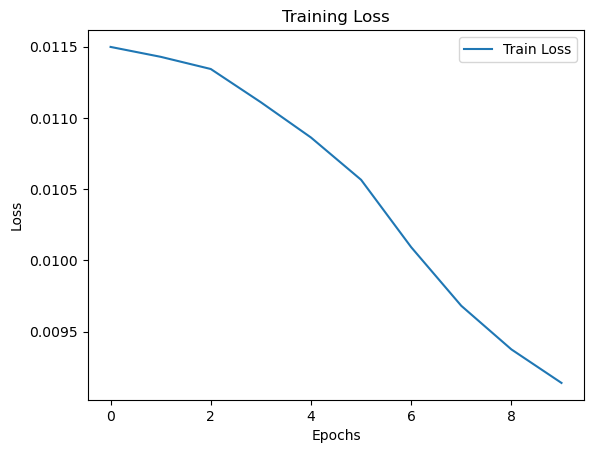

In [5]:
# Train Model
mlp = MLP(input_size=5000, hidden_layers=[128, 64], output_size=len(classes), activation='relu', learning_rate=0.01)
mlp.train(X_train, Y_train, epochs=10, batch_size=32)


In [6]:
# Evaluation Metrics
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    h_loss = hamming_loss(Y_test, Y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Hamming Loss: {h_loss:.4f}")
    return acc, h_loss


In [7]:
evaluate_model(mlp, X_test, Y_test)

Accuracy: 0.3379
Hamming Loss: 0.0101


(0.3378602186154356, 0.010069559456773767)

# I cannot Report the ordered scores for each combination as I did only a specific combination with Mini Batch because it takes a ton of time and I do not have a GPU